# Estimation of Supply

We estimated the required number(=supply) of EV ports in Georgia based on the following assumptions and process.

### Assumptions
1. The total number of vehicles will increase at a rate similar to the trend over the past 10 years.
2. The proportion of EVs within the total vehicle count for each region type (Urban, Suburban, Rural) will maintain similar trends in the near future.

### Supply Estimation Process
1. Using the TIGER/Line Urban polygon data, we classified the counties in Georgia into Urban, Suburban, and Rural regions.
2. Extract the number of vehicles in each county of Georgia from the provided data (2019, HT index).
3. Predict the total number of vehicles in Georgia for the year 2025, considering the publicly available U.S. total vehicle growth rate and Georgia's average population growth rate compared to the national average.
4. Predict the total trips of vehicles in Georgia by reflecting traffic patterns from OD data, and then scaling it by dividing by the trip ratio per vehicle to align with the total number of vehicles.
5. Using the 'EERE Report: National Plug-In Electric Vehicle' as a reference, apply the EV ratio for each region (Urban, Suburban, Rural) to predict the number of EVs in each county of Georgia.
6. Apply the optimized EV port criteria for each region, referenced from the 'EERE Report: National Plug-In Electric Vehicle', to estimate the number of EV charging ports(Lv2. fast & DCFC) required for each county in Georgia.
   - Processed Data: 'county_trip_ev_ports_lv2.shp', 'county_trip_ev_ports_DCFC.shp'
7. Distribute the estimated number of EV ports within each county to the Urban and Suburban polygons, while assigning the remaining EV ports to the Rural counties as is.
   - Data: 'lv2_supply_polygon_urban.shp', 'DCFC_supply_polygon_urban.shp'


In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Predicting Total Vehicle Count in Georgia by 2025

In [11]:
# Estimate vehicle growth rate based on U.S. and Georgia population growth from census report 2021
us_vehicle_growth_rate = 0.015  # 1.5% average U.S. growth rate 
us_population_growth_rate = 7.4 / 100  # U.S. population growth (2010-2020)
georgia_population_growth_rate = 10.6 / 100  # Georgia population growth (2010-2020)
georgia_vehicle_growth_rate = us_vehicle_growth_rate * (georgia_population_growth_rate / us_population_growth_rate)

# Print vehicle growth rate of Georgia
print(f"Predicted vehicle growth rate of Georgia: {georgia_vehicle_growth_rate * 100:.2f}%")

Predicted vehicle growth rate of Georgia: 2.15%


Predicted total vehicle of 2025 Georgia: 8278285


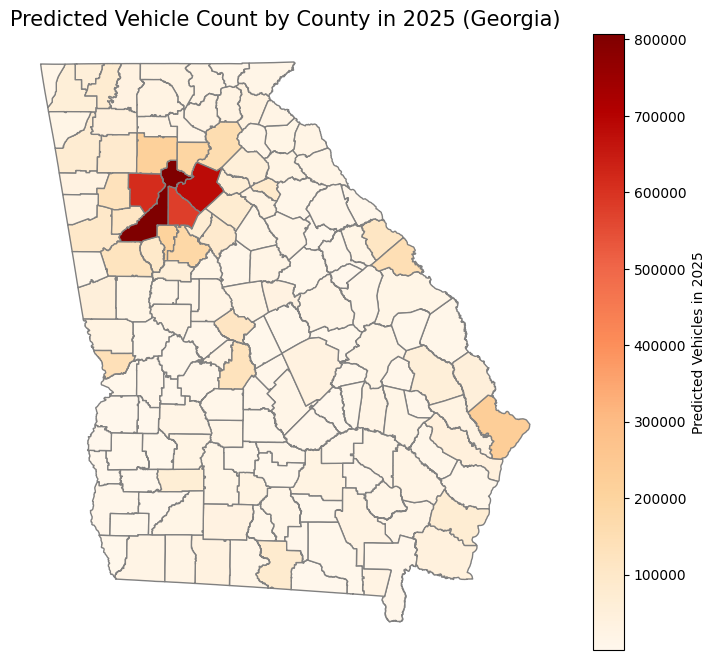

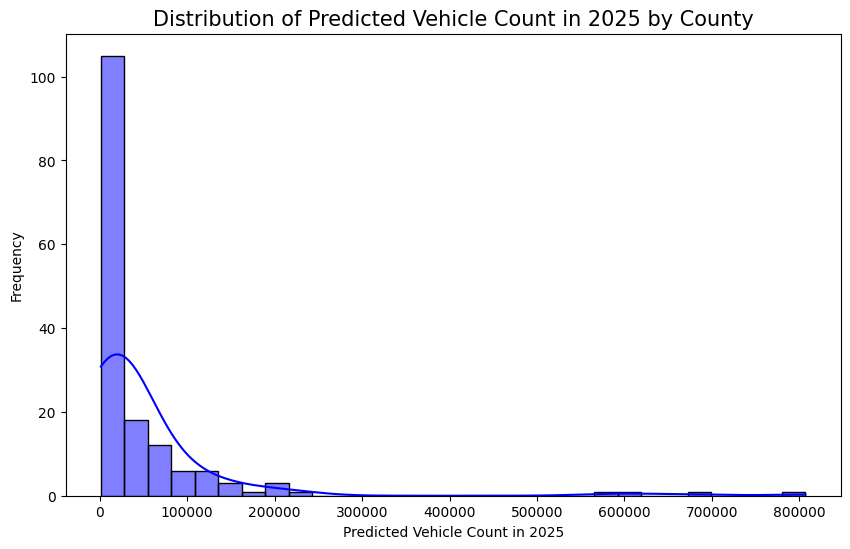

In [12]:
# Load the vehicle registration data
vehicle_data_file = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/htaindex2019_data_counties_13.csv'
county_shapefile_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/for_git_240920/Data/raw_data/Georgia_county/tl_2023_us_county.shp'
vehicle_df = pd.read_csv(vehicle_data_file)
georgia_county_gdf = gpd.read_file(county_shapefile_path)[['GEOID', 'NAMELSAD', 'geometry']]

# Clean 'county' column and calculate 'registered_vehicles'
vehicle_df['county_name'] = vehicle_df['county'].str.replace('"', '')
vehicle_df['registered_vehicles'] = vehicle_df['households'] * vehicle_df['autos_per_hh_ami']

# Calculate the vehicle growth for each year from 2020 to 2025
years = np.arange(2020, 2026)
year_deltas = years - 2019  # Calculate number of years after 2019
growth_factors = (1 + georgia_vehicle_growth_rate) ** year_deltas
vehicle_counts_by_year = vehicle_df['registered_vehicles'].values[:, None] * growth_factors

for i, year in enumerate(years):
    vehicle_df[f'vehicles_{year}'] = vehicle_df['registered_vehicles'] * growth_factors[i]

# Calculate total vehicle count for 2025
total_vehicles_2025 = int(vehicle_df['vehicles_2025'].sum())
print(f"Predicted total vehicle of 2025 Georgia: {total_vehicles_2025}")

georgia_county_gdf['GEOID'] = georgia_county_gdf['GEOID'].astype(str)
vehicle_df['county_name'] = vehicle_df['county_name'].astype(str)
vehicle_df = vehicle_df.set_index('county_name')
georgia_county_gdf['vehicles_2025'] = georgia_county_gdf['GEOID'].map(vehicle_df['vehicles_2025'])

# Step 4: Plot statistics and visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
georgia_county_gdf.plot(column='vehicles_2025', ax=ax, legend=True, cmap='OrRd', edgecolor='gray', 
                        legend_kwds={'label': "Predicted Vehicles in 2025"})
ax.set_title('Predicted Vehicle Count by County in 2025 (Georgia)', fontsize=15)
ax.set_axis_off()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(vehicle_df['vehicles_2025'], bins=30, kde=True, color='blue')
plt.title('Distribution of Predicted Vehicle Count in 2025 by County', fontsize=15)
plt.xlabel('Predicted Vehicle Count in 2025')
plt.ylabel('Frequency')
plt.show()

## Prediction based on OD data trips


Original total trips: 832528575
Calculated total trips (after adjustment): 1025813673


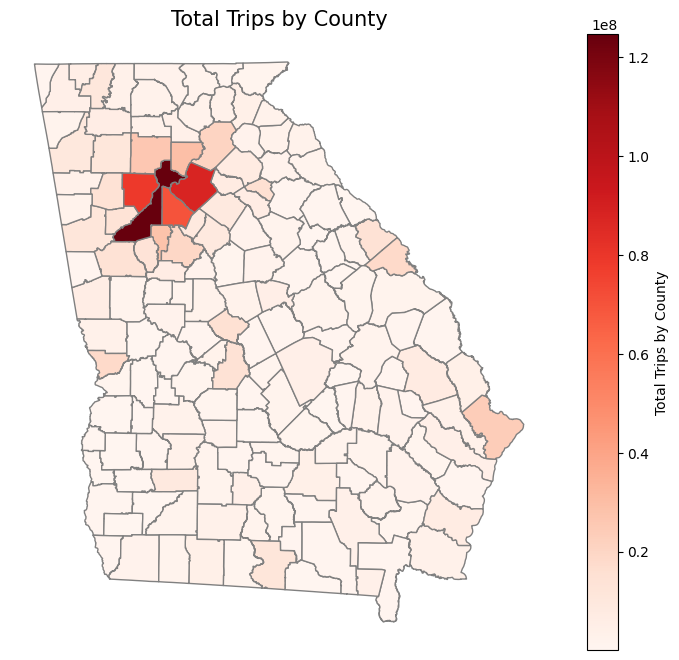

In [13]:
# Step 5: Estimating the Number of EVs and Assigning EV Ports with OD Trip Data
# - Reference: EERE Report-National Plug-In Electric Vehicle
od_trip_file = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/OD_county.xlsx'
od_trip_df = pd.read_excel(od_trip_file, sheet_name=0)

county_trip_df = pd.DataFrame(sorted(od_trip_df['origin_city'].unique()), columns=['county_name'])

# Calculate the sum of trips for each county as origin and destination
origin_trips = od_trip_df.groupby('origin_city')['mode_car'].sum().reset_index(name='origin_trips')
destination_trips = od_trip_df.groupby('destination_city')['mode_car'].sum().reset_index(name='destination_trips')
county_trip_df = pd.merge(county_trip_df, origin_trips, left_on='county_name', right_on='origin_city', how='left')
county_trip_df = pd.merge(county_trip_df, destination_trips, left_on='county_name', right_on='destination_city', how='left')
county_trip_df = county_trip_df.fillna(0)

# Calculate trips where the county is both origin and destination to avoid double-counting
both_trips = od_trip_df[od_trip_df['origin_city'] == od_trip_df['destination_city']].groupby('origin_city')['mode_car'].sum().reset_index(name='both_trips')
county_trip_df = pd.merge(county_trip_df, both_trips, left_on='county_name', right_on='origin_city', how='left')
county_trip_df['both_trips'] = county_trip_df['both_trips'].fillna(0)

# Calculate total trips for each county, subtracting the double-counted trips
county_trip_df['total_trips'] = county_trip_df['origin_trips'] + county_trip_df['destination_trips'] - county_trip_df['both_trips']
county_trip_df = county_trip_df[['county_name', 'total_trips']]
county_ev_port_gdf = georgia_county_gdf.merge(county_trip_df[['county_name', 'total_trips']], left_on='NAMELSAD', right_on='county_name', how='left')
original_trip_total = od_trip_df['mode_car'].sum()
calculated_trip_total = county_trip_df['total_trips'].sum()

print(f"Original total trips: {original_trip_total}")
print(f"Calculated total trips (after adjustment): {calculated_trip_total}")

# Step 6: Plot the total trips by county
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

county_ev_port_gdf.plot(column='total_trips', ax=ax, legend=True, cmap='Reds', edgecolor='gray', 
                        legend_kwds={'label': "Total Trips by County"})

ax.set_title('Total Trips by County', fontsize=15)
ax.set_axis_off()

# Show plot
plt.show()

# Estimating Electric Vehicle Count in Georgia by 2025

In [14]:
# Step 1: Classify Counties into Urban, Suburban, and Rural Categories using existing county_ev_port_gdf
# Load the urban area shapefile
urban_shapefile_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/for_git_240920/Data/raw_data/USA_urban_area/tl_rd22_us_uac20.shp'
urban_area_gdf = gpd.read_file(urban_shapefile_path)

# Clip the urban areas to Georgia boundary (already contained in county_ev_port_gdf)
georgia_boundary = county_ev_port_gdf.unary_union
urban_areas_within_georgia_gdf = urban_area_gdf[urban_area_gdf.intersects(georgia_boundary)]
atlanta_urban_gdf = urban_areas_within_georgia_gdf[urban_areas_within_georgia_gdf['NAMELSAD20'] == 'Atlanta, GA Urban Area']
atlanta_urban_union = atlanta_urban_gdf.geometry.unary_union
all_urban_areas_union = urban_areas_within_georgia_gdf.geometry.unary_union

# Assign region types (Urban, Suburban, Rural) to counties
county_ev_port_gdf['region_type'] = 'Rural'
county_ev_port_gdf.loc[county_ev_port_gdf.intersects(all_urban_areas_union), 'region_type'] = 'Suburban'
county_ev_port_gdf.loc[county_ev_port_gdf.intersects(atlanta_urban_union), 'region_type'] = 'Urban'

# Step 2: Adjust trip values based on ratio and predict EV counts and ports
trip_ratio = county_ev_port_gdf['total_trips'] / county_ev_port_gdf['total_trips'].sum()
adjusted_trip = trip_ratio * county_ev_port_gdf['vehicles_2025'].sum()
county_ev_port_gdf['adjusted_trip'] = adjusted_trip

weight_vehicles_2025 = 0.5
weight_trip_based = 0.5

Total LV2 Ports for Urban region: 6734
Total DCFC Ports for Urban region: 1285
Total LV2 Ports for Suburban region: 1689
Total DCFC Ports for Suburban region: 472
Total LV2 Ports for Rural region: 186
Total DCFC Ports for Rural region: 44


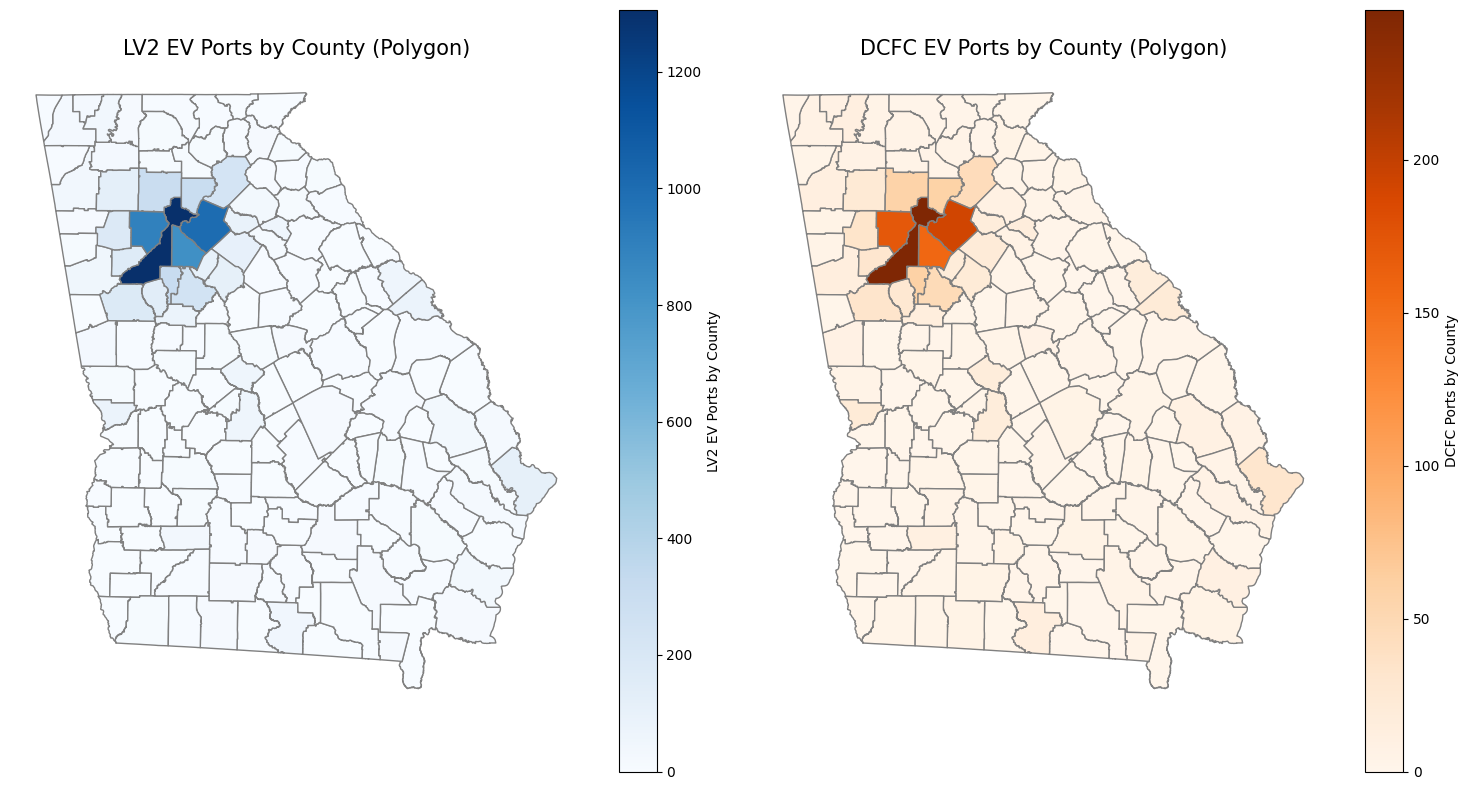

In [15]:
# EV vehicle count calculation function
def calculate_ev_vehicle_count(row):
    weighted_value = (row['vehicles_2025'] * weight_vehicles_2025) + (row['adjusted_trip'] * weight_trip_based)
    
    # Apply EV ratio based on region type
    ev_ratio = {
        'Rural': 0.005,     # Rural region: 0.5%
        'Urban': 0.04,      # Urban region: 4%
        'Suburban': 0.01    # Suburban region: 1%
    }
    return round(weighted_value * ev_ratio.get(row['region_type'], 0))

# LV2 charging port calculation function
def calculate_lv2_port_count(row):
    lv2_ratios = {
        'Urban': 36 / 1000,      # Urban: 1 port per 36 vehicles
        'Suburban': 54 / 1000,   # Suburban: 1 port per 54 vehicles
        'Rural': 79 / 1000       # Rural: 1 port per 79 vehicles
    }
    return round(row['ev_vehicle_count'] * lv2_ratios.get(row['region_type'], 0))

# DCFC (fast charging port) calculation function
def calculate_dcfc_port_count(row):
    dcfc_ratios = {
        'Urban': 1.5 / 1000,     # Urban: 1.5 DCFC per 1000 vehicles
        'Suburban': 2.2 * 1.5 / 1000,  # Suburban: 50% increase
        'Rural': 3.1 * 1.2 / 1000      # Rural: 20% increase
    }
    return row['ev_vehicle_count'] * dcfc_ratios.get(row['region_type'], 0)

# Step 1: Calculate the number of EVs
county_ev_port_gdf['ev_vehicle_count'] = county_ev_port_gdf.apply(calculate_ev_vehicle_count, axis=1)
county_ev_port_gdf['lv2_count'] = county_ev_port_gdf.apply(calculate_lv2_port_count, axis=1)
county_ev_port_gdf['dcfc_count'] = county_ev_port_gdf.apply(calculate_dcfc_port_count, axis=1)

# Step 2: Aggregate LV2 charging ports and adjust DCFC port ratio
total_lv2_port = county_ev_port_gdf['lv2_count'].sum()
total_ev_port = total_lv2_port + county_ev_port_gdf['dcfc_count'].sum()
total_ev_dcfc_port = county_ev_port_gdf['dcfc_count'].sum()

adjustment_ratio = (total_ev_port * 0.2) / total_ev_dcfc_port

# Apply the adjustment ratio to the DCFC port count
county_ev_port_gdf['dcfc_count'] *= adjustment_ratio
county_ev_port_gdf['dcfc_count'] = county_ev_port_gdf['dcfc_count'].round()

# Step 3: Output LV2 and DCFC statistics by region
regions = ['Urban', 'Suburban', 'Rural']
for region in regions:
    region_gdf = county_ev_port_gdf[county_ev_port_gdf['region_type'] == region]
    total_lv2_port_region = region_gdf['lv2_count'].sum()
    total_dcfc_port_region = region_gdf['dcfc_count'].sum()
    
    print(f"Total LV2 Ports for {region} region: {total_lv2_port_region:.0f}")
    print(f"Total DCFC Ports for {region} region: {total_dcfc_port_region:.0f}")

# Step 4: Visualize LV2 and DCFC charging ports (using subplots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Common plot parameters
plot_params = {
    'edgecolor': 'gray',
    'legend': True
}

county_ev_port_gdf.plot(column='lv2_count', ax=ax1, cmap='Blues', **plot_params, 
                        legend_kwds={'label': "LV2 EV Ports by County"})
ax1.set_title('LV2 EV Ports by County (Polygon)', fontsize=15)
ax1.set_axis_off()

county_ev_port_gdf.plot(column='dcfc_count', ax=ax2, cmap='Oranges', **plot_params, 
                        legend_kwds={'label': "DCFC Ports by County"})
ax2.set_title('DCFC EV Ports by County (Polygon)', fontsize=15)
ax2.set_axis_off()

# Display the visualization
plt.tight_layout()
plt.show()

In [16]:
# List of columns to save
columns_to_save = ['GEOID', 'NAMELSAD', 'vehicles_2025', 'total_trips', 'adjusted_trip', 
                   'region_type', 'ev_vehicle_count', 'lv2_count', 'dcfc_count', 'geometry']

# Select only the necessary columns
county_ev_port_gdf_selected = county_ev_port_gdf[columns_to_save]

# Save as a .gpkg file
output_gpkg_path = 'county_ev_port.gpkg'  # Specify the path and filename to save
county_ev_port_gdf_selected.to_file(output_gpkg_path, driver='GPKG')

print(f"Data saved to {output_gpkg_path}")

Data saved to county_ev_port.gpkg


# Split the provided urban shapefile into polygons
: Up to this point, we have estimated the EV port supply for each county. Now, we will allocate the EV port supply to urban, suburban, and rural counties.

### Process of Allocating EV Port Supply to Urban, Suburban, and Rural Counties
For this process, we used the provided urban boundary shapefile and the Georgia county boundary shapefile in the QGIS program, following these criteria:

* **Urban (Atlanta)**: Defined as the area within the Atlanta urban area.
* **Suburban**: Areas classified as urban but outside of the Atlanta urban area.
* **Rural Counties**: Counties that do not overlap with any urban or suburban polygons.

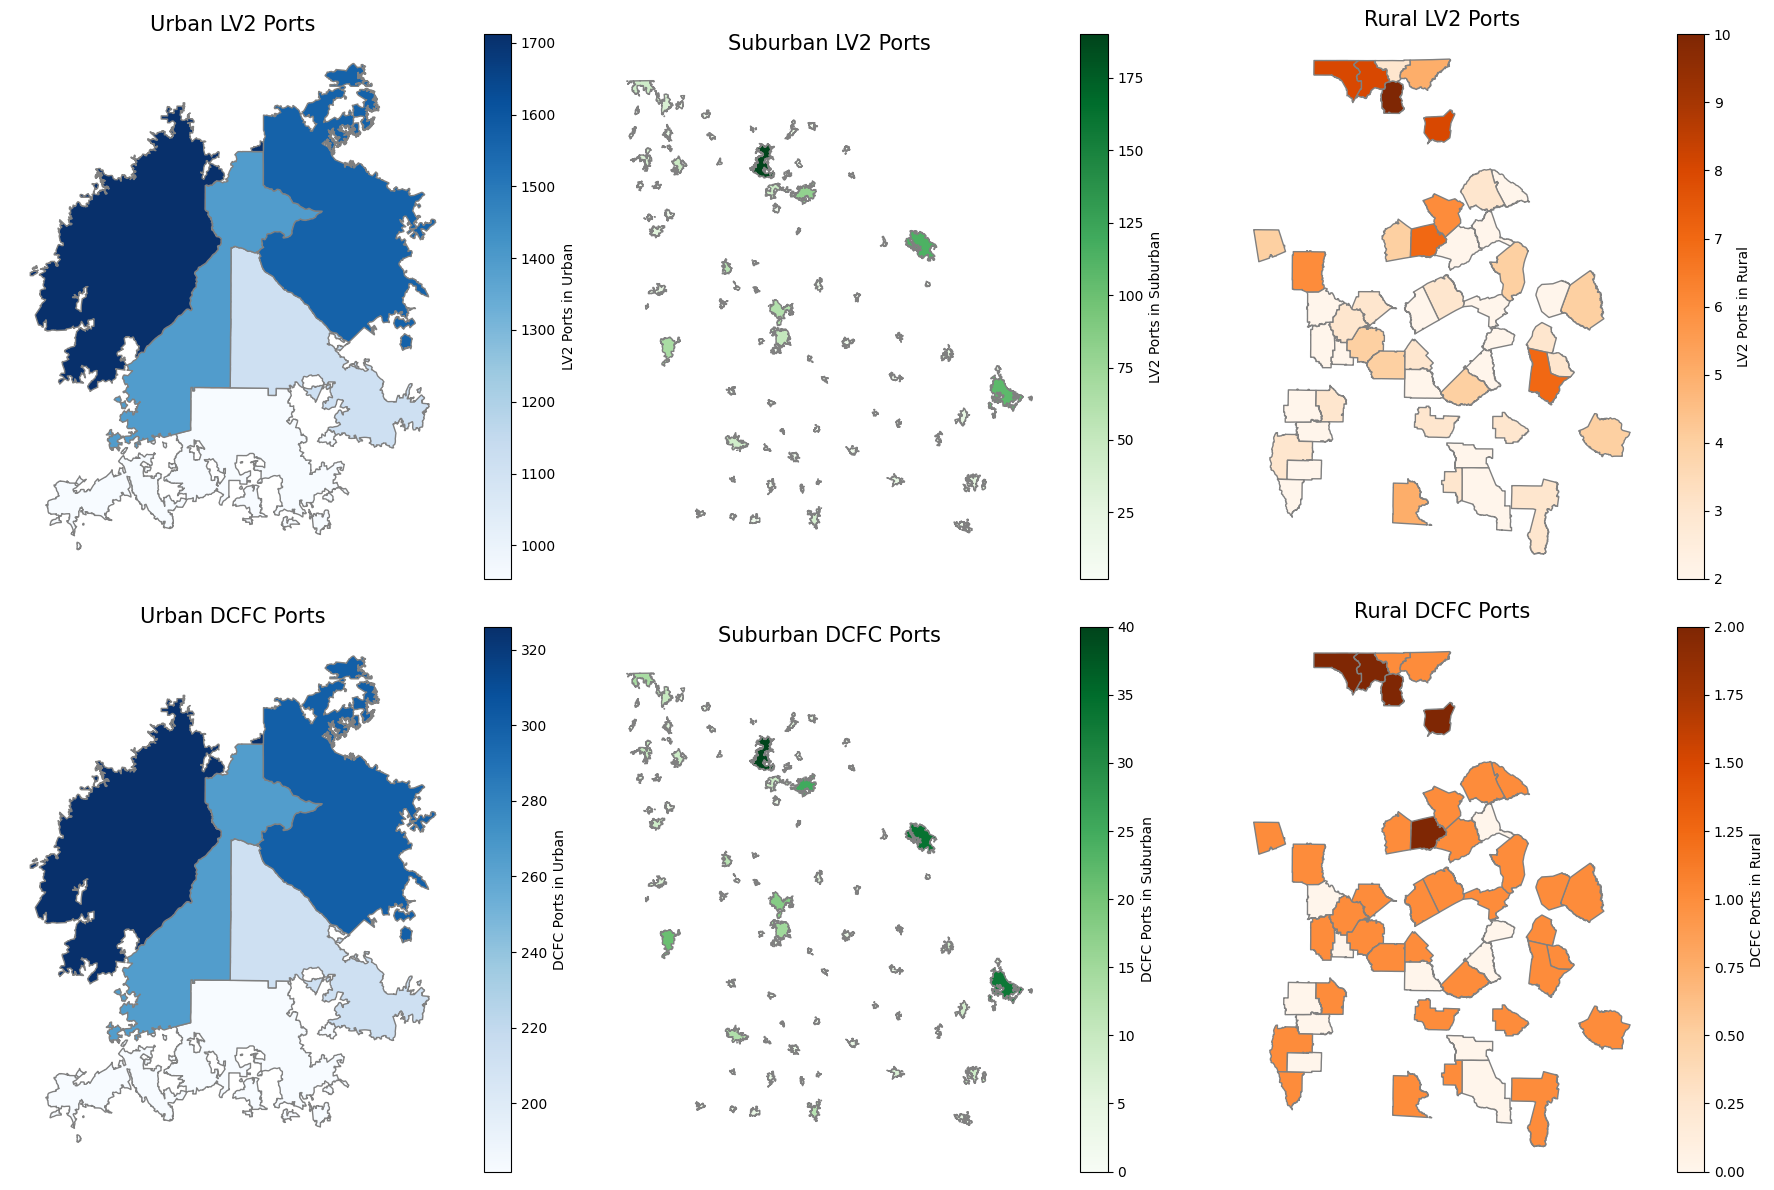

In [26]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import warnings


# Load the necessary data
combined_shp_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/georgia_urban.gpkg'  # Urban polygon data

# Load the county data and combined urban polygon shapefile
combined_polygon_gdf = gpd.read_file(combined_shp_path)
county_ev_port_gdf = county_ev_port_gdf_selected  # Preprocessed county data

# Ensure the coordinate systems are the same
county_ev_port_gdf = county_ev_port_gdf.to_crs(combined_polygon_gdf.crs)

# Step 1: Initialize LV2 and DCFC columns in the combined shapefile and distribute based on area ratio for Urban and Suburban regions
combined_polygon_gdf['lv2_count'] = 0  # Initialize lv2_count column
combined_polygon_gdf['dcfc_count'] = 0  # Initialize dcfc_count column

# Distribute LV2 and DCFC ports based on area ratio
for _, county_row in county_ev_port_gdf.iterrows():
    # Find all polygons in combined_polygon_gdf that intersect with the current county
    intersecting_polygons = combined_polygon_gdf[combined_polygon_gdf.intersects(county_row.geometry)]

    if not intersecting_polygons.empty:
        # Calculate total weighted area for normalization
        total_weighted_area = sum(
            combined_row.geometry.intersection(county_row.geometry).area * (4 if pd.notnull(combined_row['GEOID']) else 1)
            for _, combined_row in intersecting_polygons.iterrows()
        )

        # Distribute lv2_count and dcfc_count based on area ratio
        for idx, combined_row in intersecting_polygons.iterrows():
            overlap_area = combined_row.geometry.intersection(county_row.geometry).area
            weight = 4 if pd.notnull(combined_row['GEOID']) else 1
            area_ratio = (overlap_area * weight) / total_weighted_area if total_weighted_area != 0 else 0
            combined_polygon_gdf.loc[idx, 'lv2_count'] += round(county_row['lv2_count'] * area_ratio)
            combined_polygon_gdf.loc[idx, 'dcfc_count'] += round(county_row['dcfc_count'] * area_ratio)

# Step 2: Separate Urban, Suburban, and Rural regions
urban_region_gdf = combined_polygon_gdf[combined_polygon_gdf['NAMELSAD20'].str.contains("Atlanta", na=False)]  # Urban regions
suburban_region_gdf = combined_polygon_gdf[~combined_polygon_gdf['NAMELSAD20'].str.contains("Atlanta", na=False)]  # Suburban regions

# Rural regions: areas not intersecting with Urban or Suburban
urban_and_suburban_union = urban_region_gdf.unary_union.union(suburban_region_gdf.unary_union)
rural_region_gdf = county_ev_port_gdf[~county_ev_port_gdf.intersects(urban_and_suburban_union)]

# Step 3: Calculate 'p' values for Rural counties (based on lv2_count and dcfc_count)
def calculate_p_value(port_count):
    if port_count == 0:
        return 0
    elif 1 < port_count <= 5:
        return 1
    else:
        return round(port_count / 5)

rural_region_gdf['lv2_p'] = rural_region_gdf['lv2_count'].apply(calculate_p_value)
rural_region_gdf['dcfc_p'] = rural_region_gdf['dcfc_count'].apply(calculate_p_value)

# Step 4: Filter out Rural polygons where both 'lv2_p' and 'dcfc_p' are 0
rural_region_gdf = rural_region_gdf[(rural_region_gdf['lv2_p'] > 0) | (rural_region_gdf['dcfc_p'] > 0)]

# Step 5: Adjust lv2_count and dcfc_count values for Urban and Suburban based on original totals from the county data
urban_lv2_total_current = urban_region_gdf['lv2_count'].sum()
suburban_lv2_total_current = suburban_region_gdf['lv2_count'].sum()

urban_lv2_total_original = county_ev_port_gdf[county_ev_port_gdf['region_type'] == 'Urban']['lv2_count'].sum()
suburban_lv2_total_original = county_ev_port_gdf[county_ev_port_gdf['region_type'] == 'Suburban']['lv2_count'].sum()

# Calculate adjustment ratios for lv2
urban_lv2_adjustment_ratio = urban_lv2_total_original / urban_lv2_total_current if urban_lv2_total_current != 0 else 0
suburban_lv2_adjustment_ratio = suburban_lv2_total_original / suburban_lv2_total_current if suburban_lv2_total_current != 0 else 0

# Adjust and round the lv2_count values
urban_region_gdf['lv2_count'] = (urban_region_gdf['lv2_count'] * urban_lv2_adjustment_ratio).round()
suburban_region_gdf['lv2_count'] = (suburban_region_gdf['lv2_count'] * suburban_lv2_adjustment_ratio).round()

# Similarly for dcfc_count
urban_dcfc_total_current = urban_region_gdf['dcfc_count'].sum()
suburban_dcfc_total_current = suburban_region_gdf['dcfc_count'].sum()

urban_dcfc_total_original = county_ev_port_gdf[county_ev_port_gdf['region_type'] == 'Urban']['dcfc_count'].sum()
suburban_dcfc_total_original = county_ev_port_gdf[county_ev_port_gdf['region_type'] == 'Suburban']['dcfc_count'].sum()

# Calculate adjustment ratios for dcfc
urban_dcfc_adjustment_ratio = urban_dcfc_total_original / urban_dcfc_total_current if urban_dcfc_total_current != 0 else 0
suburban_dcfc_adjustment_ratio = suburban_dcfc_total_original / suburban_dcfc_total_current if suburban_dcfc_total_current != 0 else 0

# Adjust and round the dcfc_count values
urban_region_gdf['dcfc_count'] = (urban_region_gdf['dcfc_count'] * urban_dcfc_adjustment_ratio).round()
suburban_region_gdf['dcfc_count'] = (suburban_region_gdf['dcfc_count'] * suburban_dcfc_adjustment_ratio).round()

# Step 6: Visualize the results for LV2 and DCFC ports in Urban, Suburban, and Rural regions (subplots)

# Create a 2x3 subplot for LV2 and DCFC in Urban, Suburban, and Rural regions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Common plot parameters
plot_params = {
    'edgecolor': 'gray',
    'legend': True
}

# Plot LV2 for Urban, Suburban, and Rural
urban_region_gdf.plot(column='lv2_count', ax=axes[0, 0], cmap='Blues', **plot_params, legend_kwds={'label': "LV2 Ports in Urban"})
axes[0, 0].set_title('Urban LV2 Ports', fontsize=15)
axes[0, 0].set_axis_off()

suburban_region_gdf.plot(column='lv2_count', ax=axes[0, 1], cmap='Greens', **plot_params, legend_kwds={'label': "LV2 Ports in Suburban"})
axes[0, 1].set_title('Suburban LV2 Ports', fontsize=15)
axes[0, 1].set_axis_off()

rural_region_gdf.plot(column='lv2_count', ax=axes[0, 2], cmap='Oranges', **plot_params, legend_kwds={'label': "LV2 Ports in Rural"})
axes[0, 2].set_title('Rural LV2 Ports', fontsize=15)
axes[0, 2].set_axis_off()

# Plot DCFC for Urban, Suburban, and Rural
urban_region_gdf.plot(column='dcfc_count', ax=axes[1, 0], cmap='Blues', **plot_params, legend_kwds={'label': "DCFC Ports in Urban"})
axes[1, 0].set_title('Urban DCFC Ports', fontsize=15)
axes[1, 0].set_axis_off()

suburban_region_gdf.plot(column='dcfc_count', ax=axes[1, 1], cmap='Greens', **plot_params, legend_kwds={'label': "DCFC Ports in Suburban"})
axes[1, 1].set_title('Suburban DCFC Ports', fontsize=15)
axes[1, 1].set_axis_off()

rural_region_gdf.plot(column='dcfc_count', ax=axes[1, 2], cmap='Oranges', **plot_params, legend_kwds={'label': "DCFC Ports in Rural"})
axes[1, 2].set_title('Rural DCFC Ports', fontsize=15)
axes[1, 2].set_axis_off()

# Display the visualization
plt.tight_layout()
plt.show()